# 坡位分类(按照坡度和相对位置)

In [1]:
import arcpy
from arcpy.sa import *
from arcpy import env
from arcpy.conversion import *
from arcpy.management import *
from arcpy.da import *
import math

In [2]:
# 分析函数

# 取消并行处理
def disable_parallel_processing(func):
    def wrapper(*args, **kwargs):
        with arcpy.EnvManager(parallelProcessingFactor="0"):
            return func(*args, **kwargs)
    return wrapper

# 填洼
@disable_parallel_processing
def fill_dem(dem_raster):
    """参数默认为最佳"""
    fill_raster = Fill(dem_raster)
    print("fill done!")
    return fill_raster
# 流向
@disable_parallel_processing
def flowdir_dem(dem_raster,dir_index):
    """"D8算法,dir_index{1:正常流动,0:强制外向流动}"""
    if dir_index:
        flowdir_raster = FlowDirection(dem_raster,"NORMAL",None,"D8")
        return flowdir_raster
    else:
        flowdir_raster = FlowDirection(dem_raster,"FORCE", None, "D8")
        return flowdir_raster
# 流量
@disable_parallel_processing
def acc_dem(fd_raster):
    """输入流向类型D8"""
    acc_raster = FlowAccumulation(fd_raster,None,"FLOAT","D8")
    return acc_raster

# 基于焦点的正负地形
def pos_neg_dem(dem_raster,focus_size,index_):
    """focus_size:统计焦点,Test:if:(true:1正),else:0负"""
    if index_:
        pos_raster = Test(dem_raster - FocalStatistics(dem_raster,NbrRectangle(focus_size,focus_size,"CELL"),"MEAN","DATA"),"value>0")
        return pos_raster
    else:
        neg_raster = Test(dem_raster - FocalStatistics(dem_raster,NbrRectangle(focus_size,focus_size,"CELL"),"MEAN","DATA"),"value<0")
        return neg_raster
# 基于指定值的负地形
def digital_dem(dem_raster,elevation_value):
    """基于指定值于DEM作差得出的栅格"""
    return elevation_value-arcpy.Raster(dem_raster)
# 坡度
@disable_parallel_processing
def get_slope(dem_raser):
    """取消并行处理"""
    slope_raster = Slope(dem_raser,"DEGREE",1,"PLANAR","METER")
    return slope_raster
# 坡向
@disable_parallel_processing
def get_asp(dem_raster):
    """取消并行处理"""
    asp_raster = Aspect(dem_raster,"PLANAR", "METER", "GEODESIC_AZIMUTHS")
    return asp_raster
# 计算曲率
@disable_parallel_processing
def get_cur(dem_raster,count):
    """count:{0:曲率,1:[剖面曲率,平面曲率]}"""
    if count:
        asp_raster = Curvature(dem_raster,1,"profile_curve","plan_curve")
        return asp_raster
    else:
        asp_raster = Curvature(dem_raster,1,None,None)
        return asp_raster
    



In [3]:
def calc_class_raster(dem_raster, slope_raster, focus_size):
    """
    根据规则计算DEM栅格的TPI并分类：
    tpi > 1 sd : 山脊(6)，
    0.5 sd <= tpi <= 1 sd : 坡上(5)，
    -0.5 sd < tpi < 0.5 sd and slope > 8: 中坡(4)，(默认5度)
    -0.5 sd < tpi < 0.5 sd and slope <= 8: 平坡(3)，(默认5度)
    -1 sd < tpi <= -0.5 sd : 坡下(2)，
    tpi < -1 sd : 山谷(1)。
    """
    # DEM
    dem_raster = Raster(dem_raster)
    # 计算局部均值
    mean_raster = FocalStatistics(
        dem_raster, NbrRectangle(focus_size, focus_size, "CELL"), "MEAN", "DATA"
    )
    # 输出日志
    print("计算局部均值完成")
    # 计算局部标准差
    std_raster = FocalStatistics(
        dem_raster, NbrRectangle(focus_size, focus_size, "CELL"), "STD", "DATA"
    )
    # 输出日志
    print("计算局部标准差完成")
    # 计算TPI
    tpi_raster = dem_raster - mean_raster
    # 输出日志
    print("计算TPI完成")

    # 根据规则分类
    result_raster = Con(tpi_raster > std_raster, 6,
                        Con((tpi_raster > 0.5 * std_raster) & (tpi_raster <= std_raster), 5,
                            Con((tpi_raster > -0.5 * std_raster) & (tpi_raster < 0.5 * std_raster) & (slope_raster > 5), 4,
                                Con((tpi_raster > -0.5 * std_raster) & (tpi_raster < 0.5 * std_raster) & (slope_raster <= 5), 3,
                                    Con((tpi_raster > -std_raster) & (tpi_raster <= -0.5 * std_raster), 2,
                                        Con(tpi_raster < -std_raster, 1))))))
    # 输出日志
    print("计算DEM栅格的TPI并分类完成")
    
    return result_raster

In [4]:
# 焦点统计函数
# 获取均值
def get_mean(dem_raster,focus_size):
    dem_raster = Raster(dem_raster)
    mean_raster = FocalStatistics(
        dem_raster, NbrRectangle(focus_size, focus_size, "CELL"), "MEAN", "DATA"
    )
    return mean_raster

# 获取标准差
def get_std(dem_raster,focus_size):
    dem_raster = Raster(dem_raster)
    std_raster = FocalStatistics(
        dem_raster, NbrRectangle(focus_size, focus_size, "CELL"), "STD", "DATA"
        )
    return std_raster
# 获取TPI
def get_tpi(dem_raster,mean_raster,focus_size):
    dem_raster = Raster(dem_raster)
    tpi_raster = dem_raster - mean_raster
    return tpi_raster

In [5]:
# 设定工作环境
env.workspace=r"C:\Users\Runker\Desktop\slope_temp"
dem_file_path  = r"F:\ArcgisData\m5\qz\qz_mosaic_dem.tif"

In [6]:
# 允许覆盖
env.overwriteOutput = True

In [7]:
# 得到坡度
slope_raster  = get_slope(dem_file_path)
slope_raster.save('qz_slope.tif')

In [8]:
# 得到分类结果
result = calc_class_raster(dem_file_path,slope_raster,101)

计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成


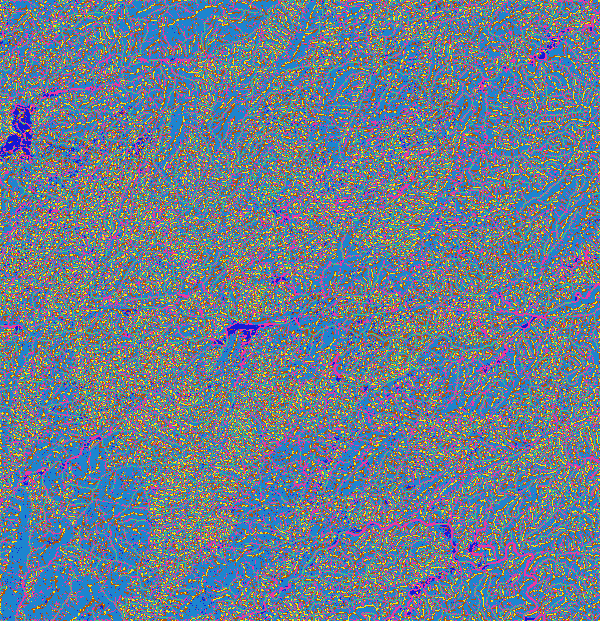

In [9]:
result

In [9]:
result.save('slope_postion_101.tif')


In [10]:
# 得到分类结果

for i in range(51,201,10):
    result = calc_class_raster(dem_file_path,Raster('SLOPE'),i)
    result.save(f'RESULT_8_{i}')

计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
计算局部均值完成
计算局部标准差完成
计算TPI完成
计算DEM栅格的TPI并分类完成
